# Derek Lamb  
# DSC 640  
# Project 3: Flight Delay Prediction & Operations Optimization  

This project focuses on predicting U.S. domestic flight arrival delays using the Bureau of Transportation Statistics (BTS) On-Time Performance dataset. By analyzing flight-level data such as scheduled departure times, actual delays, carrier information, and airport congestion, this project builds machine learning models to classify whether a flight will arrive 15 minutes or more behind schedule.  
The goal is to identify key factors that contribute to operational delays and develop insights that can support staffing, scheduling, gate assignment, and broader airport and airline operations planning.  


In [25]:
import pandas as pd
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modeling tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, confusion_matrix,
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

# Make plots a little nicer
plt.style.use("default")

# Helper: convert HHMM times (e.g., 1345) into an hour-of-day (0–23)
def hhmm_to_hour(x):
    """
    Convert integers like 5, 45, 1345 into an hour (0–23).
    If conversion fails, return NaN.
    """
    try:
        x = int(x)
        return x // 100
    except Exception:
        return np.nan



In [27]:
# Path to your downloaded BTS file
file_path = "/Users/dereklamb/Downloads/T_ONTIME_REPORTING.csv"

# Load the data (we'll let pandas infer dtypes for now)
df = pd.read_csv(file_path, low_memory=False)

print("Raw shape:", df.shape)
df.head()



Raw shape: (547271, 15)


,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,DISTANCE
0,2024,1,1,1,1/1/2024 12:00:00 AM,9E,ABE,ATL,600,-2.0,832,-35.0,0.0,0.0,692.0
1,2024,1,1,1,1/1/2024 12:00:00 AM,9E,ABE,ATL,1231,9.0,1450,-13.0,0.0,0.0,692.0
2,2024,1,1,1,1/1/2024 12:00:00 AM,9E,AEX,ATL,600,-5.0,850,-29.0,0.0,0.0,500.0
3,2024,1,1,1,1/1/2024 12:00:00 AM,9E,AEX,ATL,1631,-11.0,1917,-26.0,0.0,0.0,500.0
4,2024,1,1,1,1/1/2024 12:00:00 AM,9E,AGS,ATL,1849,-4.0,2010,-23.0,0.0,0.0,143.0


In [29]:
# Keep only the columns we need
required_cols = [
    "YEAR", "MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK",
    "FL_DATE",
    "OP_UNIQUE_CARRIER",
    "ORIGIN", "DEST",
    "CRS_DEP_TIME", "CRS_ARR_TIME",
    "DEP_DELAY", "ARR_DELAY",
    "CANCELLED", "DIVERTED",
    "DISTANCE"
]

df = df[required_cols].copy()

# Drop cancelled and diverted flights (we can't meaningfully predict arrival delay for those)
df = df[(df["CANCELLED"] == 0) & (df["DIVERTED"] == 0)]

# Drop rows with missing arrival delay
df = df.dropna(subset=["ARR_DELAY"])

# Binary target: 1 if flight is delayed 15+ minutes on arrival, else 0
df["is_delayed"] = (df["ARR_DELAY"] >= 15).astype(int)

# Convert scheduled departure time (CRS_DEP_TIME) into an hour-of-day feature
df["DEP_HOUR"] = df["CRS_DEP_TIME"].apply(hhmm_to_hour)

# Simple congestion proxy: how many flights depart from this origin in this YEAR+MONTH
df["ORIGIN_MONTHLY_FLIGHTS"] = df.groupby(
    ["YEAR", "MONTH", "ORIGIN"]
)["ORIGIN"].transform("count")

# Engineered features:
# 1) LATE_DEP: whether departure delay is already 15+ minutes (strong predictor of late arrival)
df["LATE_DEP"] = (df["DEP_DELAY"] >= 15).astype(int)

# 2) BLOCK_NUMBER: group hours into 3-hour "blocks" to capture time-of-day patterns
#    0 = 00:00–02:59, 1 = 03:00–05:59, ..., 7 = 21:00–23:59
df["BLOCK_NUMBER"] = df["DEP_HOUR"] // 3

print("After cleaning + feature engineering:", df.shape)
df[["YEAR", "MONTH", "DAY_OF_WEEK", "OP_UNIQUE_CARRIER", "ORIGIN", "DEST",
    "DEP_HOUR", "ORIGIN_MONTHLY_FLIGHTS", "DEP_DELAY", "LATE_DEP",
    "BLOCK_NUMBER", "ARR_DELAY", "is_delayed"]].head()



After cleaning + feature engineering: (525370, 20)


,YEAR,MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_HOUR,ORIGIN_MONTHLY_FLIGHTS,DEP_DELAY,LATE_DEP,BLOCK_NUMBER,ARR_DELAY,is_delayed
0,2024,1,1,9E,ABE,ATL,6,335,-2.0,0,2,-35.0,0
1,2024,1,1,9E,ABE,ATL,12,335,9.0,0,4,-13.0,0
2,2024,1,1,9E,AEX,ATL,6,147,-5.0,0,2,-29.0,0
3,2024,1,1,9E,AEX,ATL,16,147,-11.0,0,5,-26.0,0
4,2024,1,1,9E,AGS,ATL,18,244,-4.0,0,6,-23.0,0


In [31]:
# Define feature matrix X and target y

# Numeric features
numeric_features = [
    "YEAR",
    "MONTH",
    "DAY_OF_WEEK",
    "DEP_HOUR",
    "DISTANCE",
    "ORIGIN_MONTHLY_FLIGHTS",
    "DEP_DELAY",
    "LATE_DEP",
    "BLOCK_NUMBER",
]

# Categorical features
categorical_features = [
    "OP_UNIQUE_CARRIER",
    "ORIGIN",
    "DEST",
]

X = df[numeric_features + categorical_features]
y = df["is_delayed"]

# Train/test split (stratify to preserve delay rate)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Delay rate in test set:", y_test.mean())

# Preprocessing:
# - One-hot encode categorical features
# - Pass numeric features through unchanged
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features),
    ],
    remainder="drop"
)


Train shape: (420296, 12) Test shape: (105074, 12)
Delay rate in test set: 0.24061137864742943


In [33]:
# Baseline: always predict the most frequent class (usually "no delay")
baseline = Pipeline([
    ("prep", preprocess),
    ("model", DummyClassifier(strategy="most_frequent"))
])

baseline.fit(X_train, y_train)
baseline_proba = baseline.predict_proba(X_test)[:, 1]

print("Baseline ROC-AUC:", roc_auc_score(y_test, baseline_proba))
print("Baseline PR-AUC :", average_precision_score(y_test, baseline_proba))


Baseline ROC-AUC: 0.5
Baseline PR-AUC : 0.24061137864742943


LogReg ROC-AUC: 0.9210546751115436
LogReg PR-AUC : 0.8789663355375072
LogReg F1      : 0.7828003987424278
LogReg Precision: 0.759504501153188
LogReg Recall   : 0.807570603591488


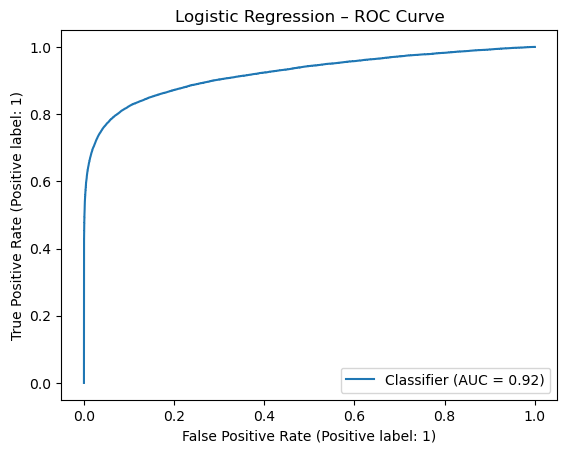

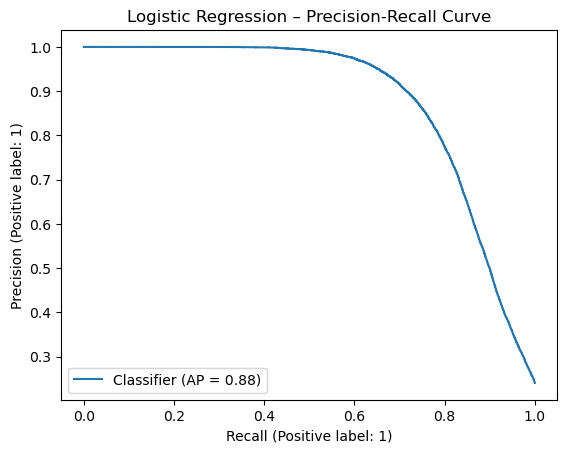

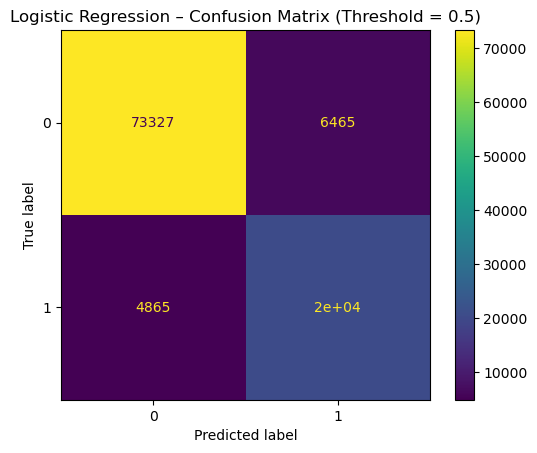

In [35]:
# Logistic Regression with class_weight='balanced' to handle class imbalance
logreg = Pipeline([
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=300, class_weight="balanced"))
])

logreg.fit(X_train, y_train)

# Predicted probabilities (for delayed class)
proba_lr = logreg.predict_proba(X_test)[:, 1]

# Use 0.5 threshold by default for LR
pred_lr = (proba_lr >= 0.5).astype(int)

print("LogReg ROC-AUC:", roc_auc_score(y_test, proba_lr))
print("LogReg PR-AUC :", average_precision_score(y_test, proba_lr))
print("LogReg F1      :", f1_score(y_test, pred_lr))
print("LogReg Precision:", precision_score(y_test, pred_lr))
print("LogReg Recall   :", recall_score(y_test, pred_lr))

# ROC curve
RocCurveDisplay.from_predictions(y_test, proba_lr)
plt.title("Logistic Regression – ROC Curve")
plt.show()

# Precision-Recall curve
PrecisionRecallDisplay.from_predictions(y_test, proba_lr)
plt.title("Logistic Regression – Precision-Recall Curve")
plt.show()

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, pred_lr)
plt.title("Logistic Regression – Confusion Matrix (Threshold = 0.5)")
plt.show()


Training rows for RF: 100000
RF ROC-AUC: 0.6252051852596198
RF PR-AUC: 0.3305517952588737
RF F1: 0.41118941078749227
RF Precision: 0.3108995137763371
RF Recall: 0.6069931176330986


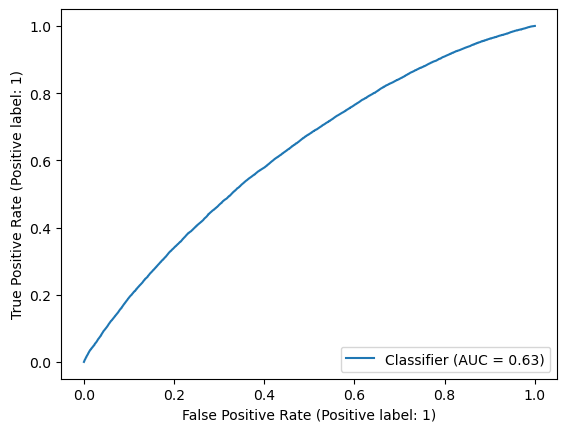

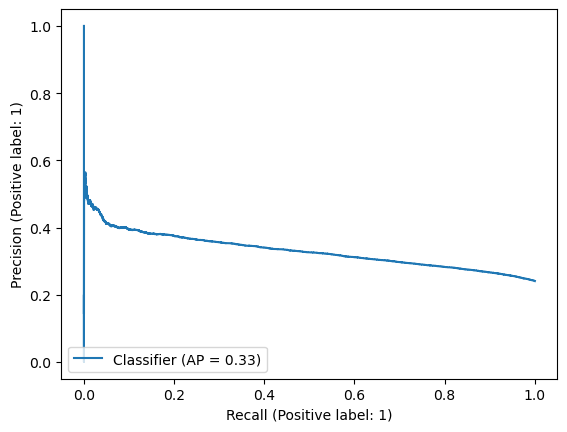

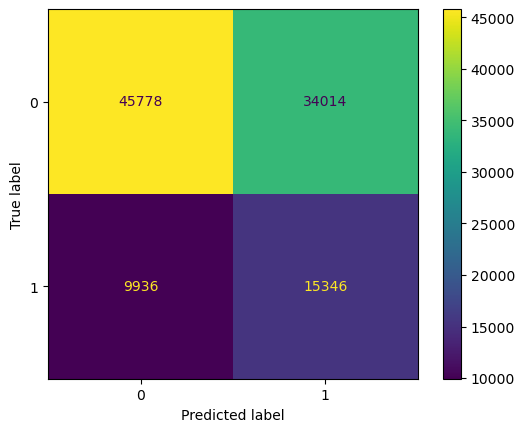

In [17]:
from sklearn.ensemble import RandomForestClassifier

# ---- SAMPLE THE TRAINING DATA TO SPEED THINGS UP ----
# Keep at most 100,000 rows (stratified so class balance is preserved)
max_rows = 100_000
if len(X_train) > max_rows:
    X_train_small, _, y_train_small, _ = train_test_split(
        X_train, y_train,
        train_size=max_rows,
        stratify=y_train,
        random_state=42
    )
else:
    X_train_small, y_train_small = X_train, y_train

print("Training rows for RF:", len(X_train_small))

rf = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=100,         # was 300
        max_depth=12,             # limit depth
        min_samples_leaf=50,      # avoid tiny leaves
        random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1
    ))
])

rf.fit(X_train_small, y_train_small)

proba_rf = rf.predict_proba(X_test)[:, 1]
pred_rf = (proba_rf >= 0.5).astype(int)

print("RF ROC-AUC:", roc_auc_score(y_test, proba_rf))
print("RF PR-AUC:", average_precision_score(y_test, proba_rf))
print("RF F1:", f1_score(y_test, pred_rf))
print("RF Precision:", precision_score(y_test, pred_rf))
print("RF Recall:", recall_score(y_test, pred_rf))

RocCurveDisplay.from_predictions(y_test, proba_rf)
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, proba_rf)
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, pred_rf)
plt.show()


In [37]:
from sklearn.utils import resample

# To keep RF training reasonable, sample up to 100k training rows
max_train_rows = 100_000
if len(X_train) > max_train_rows:
    X_train_sample, _, y_train_sample, _ = train_test_split(
        X_train, y_train,
        train_size=max_train_rows,
        stratify=y_train,
        random_state=42
    )
else:
    X_train_sample, y_train_sample = X_train, y_train

print("Random Forest training rows:", len(X_train_sample))

# Define a reasonably strong but not insane Random Forest
rf = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=200,
        max_depth=25,
        min_samples_leaf=4,
        min_samples_split=8,
        bootstrap=True,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

rf.fit(X_train_sample, y_train_sample)

# Predicted probabilities for the test set
proba_rf = rf.predict_proba(X_test)[:, 1]

print("RF ROC-AUC:", roc_auc_score(y_test, proba_rf))
print("RF PR-AUC :", average_precision_score(y_test, proba_rf))
print("RF probability range (min, max, mean):",
      proba_rf.min(), proba_rf.max(), proba_rf.mean())


Random Forest training rows: 100000
RF ROC-AUC: 0.9295581758656677
RF PR-AUC : 0.873444899680924
RF probability range (min, max, mean): 0.11289177667491666 0.9412484200503415 0.3704890962048713


Threshold used: 0.35
RF F1        : 0.7897171047560316
RF Precision : 0.770011273957159
RF Recall    : 0.8104580333834348


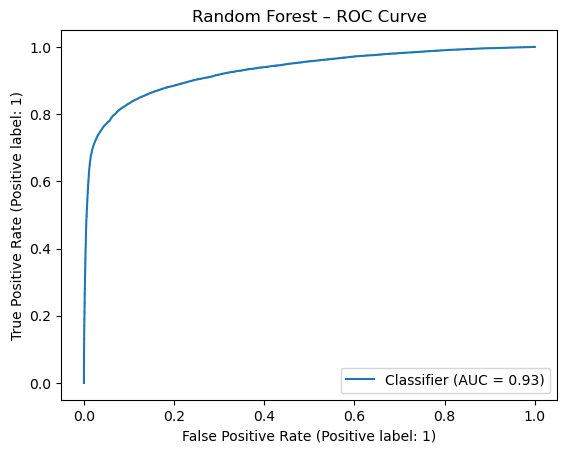

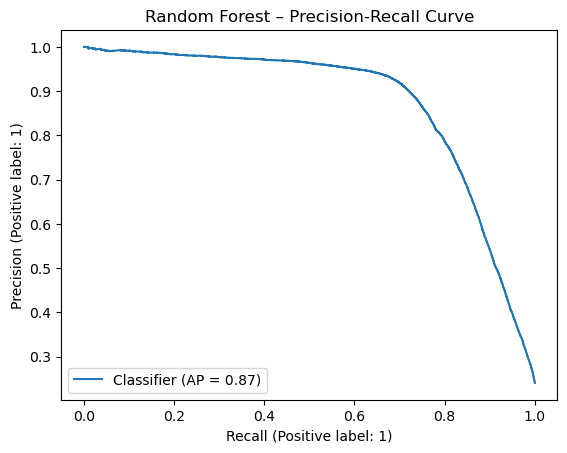

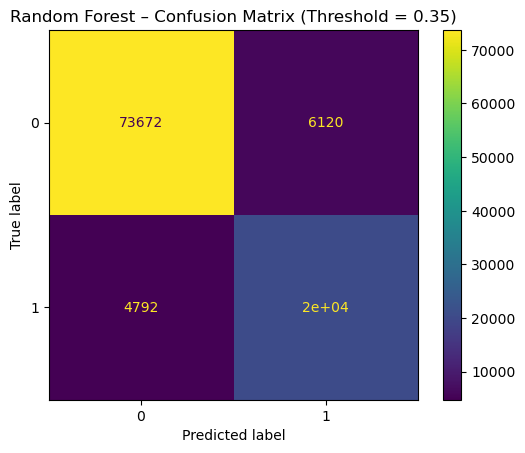

In [39]:
threshold = 0.35 

pred_rf = (proba_rf >= threshold).astype(int)

print("Threshold used:", threshold)
print("RF F1        :", f1_score(y_test, pred_rf, zero_division=0))
print("RF Precision :", precision_score(y_test, pred_rf, zero_division=0))
print("RF Recall    :", recall_score(y_test, pred_rf, zero_division=0))

RocCurveDisplay.from_predictions(y_test, proba_rf)
plt.title("Random Forest – ROC Curve")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, proba_rf)
plt.title("Random Forest – Precision-Recall Curve")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, pred_rf)
plt.title(f"Random Forest – Confusion Matrix (Threshold = {threshold})")
plt.show()


In [41]:
# Explore how precision/recall/F1 change for different thresholds
thresholds = np.round(np.arange(0.10, 0.90, 0.05), 2)
rows = []

for t in thresholds:
    preds_t = (proba_rf >= t).astype(int)
    rows.append({
        "threshold": t,
        "precision": precision_score(y_test, preds_t, zero_division=0),
        "recall": recall_score(y_test, preds_t, zero_division=0),
        "f1": f1_score(y_test, preds_t, zero_division=0)
    })

perf_df = pd.DataFrame(rows)
perf_df


,threshold,precision,recall,f1
0,0.10,0.240611,1.000000,0.387892
1,0.15,0.243064,0.999446,0.391031
2,0.20,0.315584,0.978957,0.477302
3,0.25,0.498020,0.915473,0.645103
4,0.30,0.666615,0.855589,0.749372
5,0.35,0.770011,0.810458,0.789717
6,0.40,0.804395,0.789059,0.796653
7,0.45,0.812161,0.781386,0.796476
8,0.50,0.813074,0.780239,0.796318
9,0.55,0.813245,0.780081,0.796318


In [43]:
summary = {
    "n_train": len(X_train),
    "n_test": len(X_test),
    "delay_rate_test": float(y_test.mean()),
    "baseline_roc_auc": float(roc_auc_score(y_test, baseline_proba)),
    "logreg_roc_auc": float(roc_auc_score(y_test, proba_lr)),
    "rf_roc_auc": float(roc_auc_score(y_test, proba_rf)),
}

summary


{'n_train': 420296,
 'n_test': 105074,
 'delay_rate_test': 0.24061137864742943,
 'baseline_roc_auc': 0.5,
 'logreg_roc_auc': 0.9210546751115436,
 'rf_roc_auc': 0.9295581758656677}

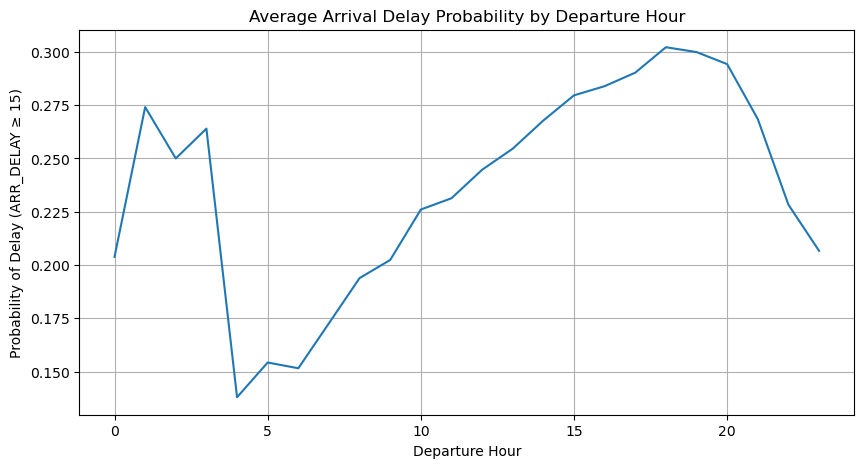

In [45]:
delay_by_hour = df.groupby("DEP_HOUR")["is_delayed"].mean()

plt.figure(figsize=(10,5))
delay_by_hour.plot(kind='line')
plt.title("Average Arrival Delay Probability by Departure Hour")
plt.xlabel("Departure Hour")
plt.ylabel("Probability of Delay (ARR_DELAY ≥ 15)")
plt.grid(True)
plt.show()


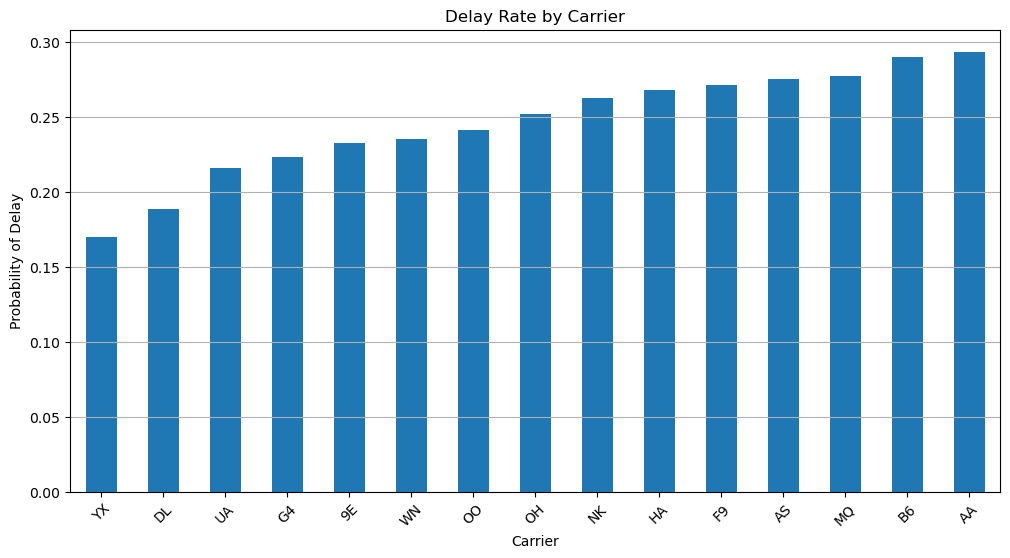

In [46]:
carrier_delay = df.groupby("OP_UNIQUE_CARRIER")["is_delayed"].mean().sort_values()

carrier_delay.plot(kind='bar', figsize=(12,6))
plt.title("Delay Rate by Carrier")
plt.xlabel("Carrier")
plt.ylabel("Probability of Delay")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


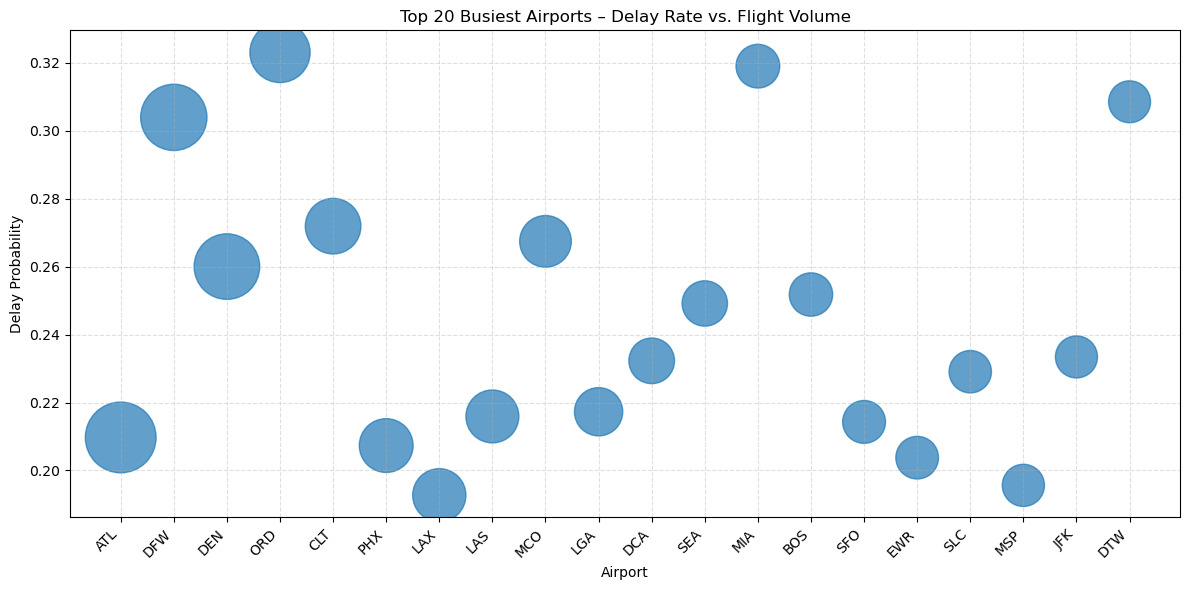

In [53]:
top20 = airport_stats.sort_values("flight_count", ascending=False).head(20)

plt.figure(figsize=(12,6))
plt.scatter(
    top20.index,
    top20["delay_rate"],
    s=top20["flight_count"] / 10,
    alpha=0.7
)
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Busiest Airports – Delay Rate vs. Flight Volume")
plt.xlabel("Airport")
plt.ylabel("Delay Probability")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


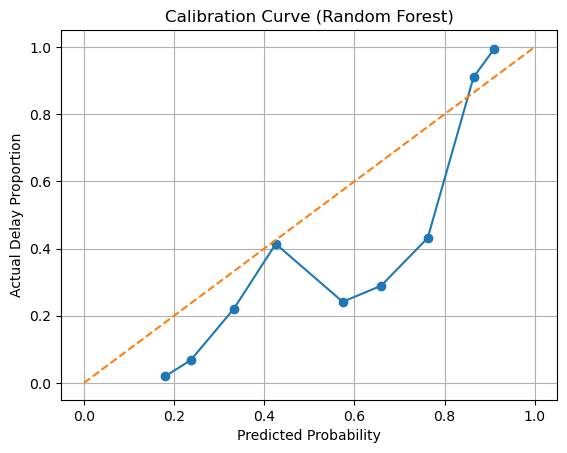

In [51]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, proba_rf, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1], [0,1], linestyle="--")
plt.title("Calibration Curve (Random Forest)")
plt.xlabel("Predicted Probability")
plt.ylabel("Actual Delay Proportion")
plt.grid(True)
plt.show()
